In [166]:
%matplotlib inline
import numpy as np
from astropy.io import ascii, fits
import matplotlib.pyplot as plt
from photutils import aperture_photometry as ap
from photutils import CircularAperture, CircularAnnulus
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import wcs
from hyperion.model import ModelOutput
import astropy.constants as const

pc = const.pc.cgs.value
AU = const.au.cgs.value

## Calculate the radial intensity profile by taking the difference between apertues

In [178]:
# Read in data and set up coversions
# 500 um
im500_hdu = fits.open('/Users/yaolun/bhr71/data/photometry/herschel_photometry/'+
               '1342226633/level2/extdPLW/hspireplw1342226633_20pxmp_1431669349619.fits')
# 160 um
im160_hdu = fits.open('/Users/yaolun/bhr71/data/photometry/herschel_photometry/'+
               '1342224922/level2/HPPPMAPR/hpacs1342224922_20hpppmapr_00_1431606963820.fits')
im_data = [im160_hdu, im500_hdu]
err_index = [5,6]
r_data = []
I_data = []
I_err_data = []

for im_hdu in im_data:
    im = im_hdu[1].data
    im_err = im_hdu[err_index[im_data.index(im_hdu)]].data
    w = wcs.WCS(im_hdu[1].header)

    coord = SkyCoord('12 01 36.3 -65 08 53.0', unit=(u.hourangle, u.deg))
    pixcoord = w.wcs_world2pix(coord.ra.degree, coord.dec.degree, 1)
    pix2arcsec = abs(im_hdu[1].header['CDELT1'])*3600.
    # convert intensity unit from MJy/sr to Jy/pixel
    factor = 1e6/4.25e10*abs(im_hdu[1].header['CDELT1']*im_hdu[1].header['CDELT2'])*3600**2

    # radial grid in arcsec
    annulus_width = 10
    r = np.arange(10, 200, annulus_width, dtype=float)
    I = np.empty_like(r[:-1])
    I_err = np.empty_like(r[:-1])

    # iteration
    for ir in range(len(r)-1):
        aperture = CircularAnnulus((pixcoord[0],pixcoord[1]), r_in=r[ir]/pix2arcsec, r_out=r[ir+1]/pix2arcsec)
    #     print aperture.r_in
        phot = ap(im, aperture, error=im_err)
        I[ir] = phot['aperture_sum'].data * factor / aperture.area()
        I_err[ir] = phot['aperture_sum_err'].data * factor / aperture.area()
        print r[ir], I[ir] , I_err[ir]
        
    r_data.append(r)
    I_data.append(I)
    I_err_data.append(I_err)

10.0 0.000275207239662 8.46386081799e-09
20.0 5.46950764115e-05 6.61575126019e-09
30.0 1.83792395803e-05 5.67517174507e-09
40.0 8.65093185943e-06 5.10023199935e-09
50.0 4.01847259082e-06 4.72214868112e-09
60.0 2.28887451702e-06 4.45648824324e-09
70.0 1.58257336373e-06 4.26679744423e-09
80.0 9.89278083671e-07 4.14293385385e-09
90.0 5.54426907943e-07 4.07072342772e-09
100.0 3.85591312457e-07 4.05202949793e-09
110.0 2.77638666547e-07 4.07635222247e-09
120.0 1.67220111817e-07 4.161046882e-09
130.0 8.55447728128e-08 4.32197753407e-09
140.0 4.03031712427e-08 4.58593159024e-09
150.0 -1.59778373438e-08 4.98980917502e-09
160.0 -7.17371944022e-09 5.59612455277e-09
170.0 -3.27541681788e-08 6.65469585201e-09
180.0 -3.18053084403e-08 1.59887760691e-08
10.0 2.47951831719 0.0309567699475
20.0 1.80781725589 0.0197113985214
30.0 1.17608385102 0.0127737530684
40.0 0.754192242162 0.00741162789883
50.0 0.530199632018 0.00346750045954
60.0 0.409669559252 0.00130042405731
70.0 0.345632529506 0.0008231754696

/Users/yaolun/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in log10
/Users/yaolun/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in log10
/Users/yaolun/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in log10


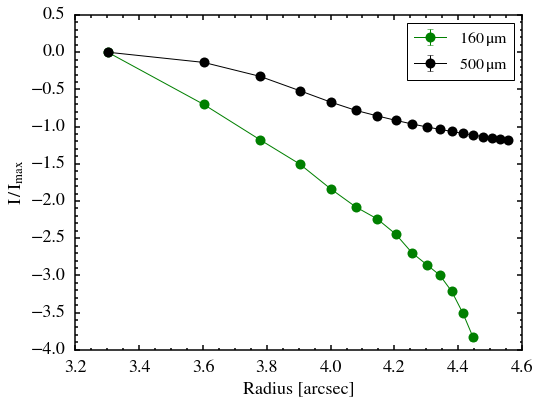

In [180]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

label = [r'$\rm{160\,\mu m}$', r'$\rm{500\,\mu m}$']
color = ['g','k']

for i in range(len(I_data)):
    I = I_data[i]
    I_err = I_err_data[i]
    r = r_data[i]
    
    I_hi = np.log10((I+I_err)/I.max())-np.log10(I/I.max())
    I_low = np.log10(I/I.max())-np.log10((I-I_err)/I.max())

    i = ax.errorbar(np.log10(r[:-1]*dstar), np.log10(I/I.max()),
                    yerr=(I_low, I_hi), color=color[i], marker='o', linestyle='-', 
                    mec='None', markersize=10, label=label[i])

# ax.legend([i], [r'$\rm{500\,\mu m}$'], fontsize=16, numpoints=1, loc='upper right')
ax.legend(fontsize=16, numpoints=1, loc='upper right')
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)
ax.set_xlabel('Radius [arcsec]', fontsize=18)
ax.set_ylabel(r'$\rm{I\,/\,I_{max}}$', fontsize=18)

fig.savefig('/Users/yaolun/test/radial_profile_160_500.pdf', format='pdf', dpi=300, bbox_inches='tight')

## Do the same thing for simulations

In [155]:
# read in from RTout
rtout = ModelOutput('/Users/yaolun/bhr71/hyperion/model79.rtout')
# setting up parameters
dstar = 200.
group = 8
wave = 500.0

im = rtout.get_image(group=group, inclination=0, distance=dstar*pc, units='Jy', uncertainties=True)

# Find the closest wavelength
iwav = np.argmin(np.abs(wave - im.wav))
# avoid zero when log, and flip the image
val = im.val[::-1, :, iwav]
unc = im.unc[::-1, :, iwav]

w = np.degrees(max(rtout.get_quantities().r_wall) / im.distance) * 3600
npix = len(val[:,0])
pix2arcsec = 2*w/npix

In [157]:
# radial grid in arcsec
annulus_width = 10
r = np.arange(10, 200, annulus_width, dtype=float)
I_sim = np.empty_like(r[:-1])
I_sim_err = np.empty_like(r[:-1])

# iteration
for ir in range(len(r)-1):
    aperture = CircularAnnulus((npix/2.+0.5, npix/2.+0.5), r_in=r[ir]/pix2arcsec, r_out=r[ir+1]/pix2arcsec)
#     print aperture.r_in
    phot = ap(val, aperture, error=unc)
    I_sim[ir] = phot['aperture_sum'].data / aperture.area()
    I_sim_err[ir] = phot['aperture_sum_err'].data / aperture.area()
    print r[ir], I_sim[ir], I_sim_err[ir]

10.0 0.0281436143124 0.000226083458947
20.0 0.0104700841846 8.5348204352e-05
30.0 0.00529501227527 4.34756641317e-05
40.0 0.00312053421118 2.59845356703e-05
50.0 0.00202953414461 1.71376716235e-05
60.0 0.0013743020377 1.18964766607e-05
70.0 0.000993473349476 8.78295008292e-06
80.0 0.000730044350939 6.63291808717e-06
90.0 0.000544757839826 5.13336212581e-06
100.0 0.000422078056381 4.10844297714e-06
110.0 0.000327208990358 3.31831540213e-06
120.0 0.000253674173475 2.71155673192e-06
130.0 0.00019753487939 2.24019857485e-06
140.0 0.000156650714813 1.88795690614e-06
150.0 0.000122280136117 1.58874916058e-06
160.0 9.30661722117e-05 1.31597015553e-06
170.0 6.86836165923e-05 1.05674560776e-06
180.0 4.59905615077e-05 7.86012669279e-07


In [149]:
print np.log10(I_sim/I_sim.max())
print np.log10(I/I.max())
print np.log10(r[:-1])

[   0.                  -inf -312.11573236 -312.11573048 -312.11573048
 -312.11573047 -312.11573046 -312.11573056 -312.11573046 -312.11573045
 -312.1172745  -312.10307305 -312.09885982 -312.09922984 -312.12237438
 -312.12235404 -312.1181858  -306.35191286]
[ 0.         -0.70171162 -1.17533232 -1.50259696 -1.83559884 -2.08003787
 -2.240296   -2.44434147 -2.69581555 -2.85353261 -2.9961799  -3.21637134
 -3.50746638 -3.83432063         nan         nan         nan         nan]
[ 1.          1.30103     1.47712125  1.60205999  1.69897     1.77815125
  1.84509804  1.90308999  1.95424251  2.          2.04139269  2.07918125
  2.11394335  2.14612804  2.17609126  2.20411998  2.23044892  2.25527251]


/Users/yaolun/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Users/yaolun/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


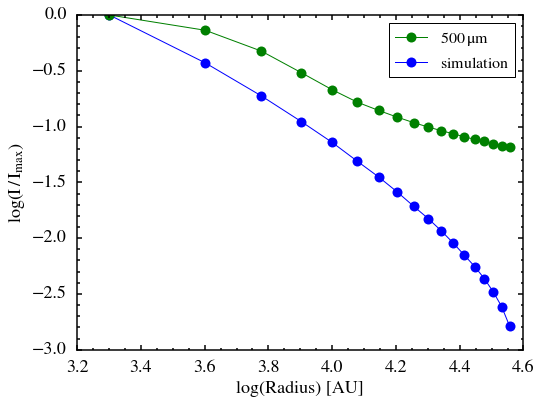

In [109]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

i_sim, = ax.plot(np.log10(r[:-1]*dstar), np.log10(I_sim/I_sim.max()), 'o-', mec='None', markersize=10)
i, = ax.plot(np.log10(r[:-1]*dstar), np.log10(I/I.max()), 'o-', mec='None', markersize=10)

ax.legend([i, i_sim], [r'$\rm{500\,\mu m}$', r'$\rm{simulation}$'], fontsize=16, numpoints=1, loc='upper right')
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)
ax.set_xlabel('log(Radius) [AU]', fontsize=18)
ax.set_ylabel(r'$\rm{log(I\,/\,I_{max})}$', fontsize=18)